In [28]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

%matplotlib inline 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec 
import mpld3 as mpl


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC


import xgboost as xgb

['diabetes.csv']


In [3]:
data = pd.read_csv('../input/diabetes.csv')

In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [32]:
print(len(data))

768


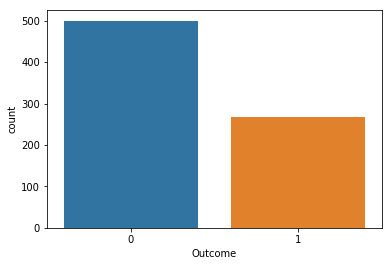

In [5]:
import seaborn as sns

ax = sns.countplot(data.iloc[:,-1],label="Count") 

In [10]:
train, test = train_test_split(data, test_size = 0.25, random_state = 2)

In [20]:
X_train, Y_train = train.iloc[:,:-1].values, train.iloc[:,-1]
X_test, Y_test = test.iloc[:,:-1].values, test.iloc[:,-1]

In [11]:
def classification_model(model, data, predictors, outcome):
  model.fit(data[predictors], data[outcome])
  predictions = model.predict(data[predictors])
  accuracy = metrics.accuracy_score(predictions,data[outcome])
  print("Accuracy : %s" % "{0:.3%}".format(accuracy))

  #k-fold cross-validation with 5 folds
  kf = KFold(data.shape[0], n_folds=5)
  error = []
  for train, test in kf:
    # Filter training data
    train_predictors = (data[predictors].iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = data[outcome].iloc[train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
    
    print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))
    
  #Fit the model again so that it can be refered outside the function:
  model.fit(data[predictors],data[outcome]) 

# 1 - Random Forest

In [ ]:
def age_group(data):
    

In [19]:
indp_var=list(data.columns[0:-1])
outcome_var = 'Outcome'
model = RandomForestClassifier(n_estimators=100, min_samples_split=25, max_depth=7, max_features=6)
classification_model(model,train,indp_var,outcome_var)

Accuracy : 87.326%
Cross-Validation Score : 71.552%
Cross-Validation Score : 72.732%
Cross-Validation Score : 74.285%
Cross-Validation Score : 74.410%
Cross-Validation Score : 75.006%


In [33]:
classification_model(model, test, indp_var, outcome_var)

Accuracy : 86.458%
Cross-Validation Score : 76.923%
Cross-Validation Score : 74.359%
Cross-Validation Score : 75.888%
Cross-Validation Score : 76.653%
Cross-Validation Score : 77.112%


In [34]:
import _pickle as cPickel
with open('diabetes.pickle', 'wb') as f:
    cPickel.dump(model, f)

#  2 - XGBoost

In [26]:
dtrain = xgb.DMatrix(X_train, Y_train)
dtest = xgb.DMatrix(X_test, Y_test)
param = {'max_depth' : 6, 'eta' : 0.1, 'objective' : 'binary:logistic', 'seed' : 42}
num_round = 50
bst = xgb.train(param, dtrain, num_round, [(dtest, 'test'), (dtrain, 'train')])

[0]	test-error:0.291667	train-error:0.159722
[1]	test-error:0.270833	train-error:0.142361
[2]	test-error:0.270833	train-error:0.145833
[3]	test-error:0.270833	train-error:0.114583
[4]	test-error:0.265625	train-error:0.116319
[5]	test-error:0.265625	train-error:0.112847
[6]	test-error:0.255208	train-error:0.118056
[7]	test-error:0.260417	train-error:0.112847
[8]	test-error:0.255208	train-error:0.112847
[9]	test-error:0.239583	train-error:0.104167
[10]	test-error:0.244792	train-error:0.105903
[11]	test-error:0.229167	train-error:0.098958
[12]	test-error:0.234375	train-error:0.100694
[13]	test-error:0.25	train-error:0.090278
[14]	test-error:0.244792	train-error:0.092014
[15]	test-error:0.244792	train-error:0.088542
[16]	test-error:0.234375	train-error:0.083333
[17]	test-error:0.229167	train-error:0.086806
[18]	test-error:0.239583	train-error:0.085069
[19]	test-error:0.223958	train-error:0.081597
[20]	test-error:0.229167	train-error:0.083333
[21]	test-error:0.234375	train-error:0.076389
[2

In [27]:
preds = bst.predict(dtest)
preds[preds > 0.5] = 1
preds[preds <= 0.5] = 0
print(accuracy_score(preds, Y_test), 1 - accuracy_score(preds, Y_test))

0.7447916666666666 0.25520833333333337


# 3 - SVM

In [29]:
clf = SVC(kernel="linear", C=0.1)
clf.fit(X_train, Y_train)
y_eval = clf.predict(X_test)

In [31]:
print(accuracy_score(y_eval, Y_test))

0.7708333333333334
